# Análisis de sistemas electorales para la Cámara de Diputadas y Diputados de Chile

En el presente informe, se utilizan los datos de las elecciones parlamentarias
de Chile de 2021 para simular la distribución de escaños en la Cámara de
Diputadas y Diputados bajo distintos sistemas electorales. Para cada sistema,
se presentan ventajas y desventajas, justificadas mediante un análisis numérico
de los resultados (e.g. cálculo del [índice de
Gallagher](https://en.wikipedia.org/wiki/Gallagher_index) y el [índice de
Loosemore-Hanby](https://en.wikipedia.org/wiki/Loosemore%E2%80%93Hanby_index)
para ver disproporcionalidad, y de la [cantidad efectiva de
partidos](https://en.wikipedia.org/wiki/Effective_number_of_parties) para ver
fragmentación).

Se proponen los siguientes sistemas (en cursiva los que aún no se han
analizado):

- Proporcional por distrito
    - D'Hondt estándar (actualmente usado)
    - *D'Hondt con umbral nacional (actualmente en discusión)*
    - *D'Hondt sin pactos*
- *Proporcional nacional*
    - *D'Hondt nacional*
    - *D'Hondt nacional con umbral electoral*
    - *D'Hondt nacional sin pactos*
- *Bipartidistas*
    - *Binomial*
    - *Uninominal (first-past-the-post)*
- *Mixtos*
    - *Mixed-Member Proportional / Additional Member System*
    - *D'Hondt con escaños niveladores*
    - *Binomial con escaños niveladores*
- *Sistema biproporcional*

In [1]:
import numpy as np
import pandas as pd

from data_load_utils import *
from systems import *
from apportionment import Apportionment

## Carga de datos

Primero, se carga a un dataframe el archivo `datos.csv` con una representación
ordenada de todas las votaciones obtenidas durante la elección parlamentaria,
exceptuando candidatos independientes fuera de pacto. La creación de este
archivo fue a partir de los resultados oficiales de las elecciones entregados
por el [Tricel](https://tricel.cl/resultados-de-elecciones/). En el anexo
[`carga_datos.ipynb`](carga_datos.ipynb) se puede ver este proceso con mayor
profundidad.

In [2]:
df = pd.read_csv("datos.csv", index_col=0)

Para las simulaciones en las cuales no se utilizan pactos, creamos una copia
del dataframe donde el pacto de cada candidato es reemplazado por su partido.

In [3]:
df_no_pact = df.copy()
df_no_pact["pact"] = df_no_pact["party"]

En las simulaciones usando D'Hondt, se mantendrá la distribución de escaños del
congreso actual para cada uno de los 28 distritos.

In [4]:
district_seats = pd.Series(
    np.array(
        [3, 3, 5, 5, 7, 8, 8, 8, 7, 8, 6, 7, 5, 6,
        5, 4, 7, 4, 5, 8, 5, 4, 7, 5, 4, 5, 3, 3]
    ),
    index=range(1, 29)
)

Para las simulaciones que utilizan distritos binomiales y uninominales, se
deben redistribuir los distritos existentes. A cada distrito se le asignó una
cantidad de subdistritos en los cuales dividirse, según su cantidad total de
votantes. La asignación se realizó usando el [método de
Huntington-Hill](https://en.wikipedia.org/wiki/Huntington%E2%80%93Hill_method),
el mismo usado para la asignación de escaños a los distintos estados de los
Estados Unidos en su Cámara de Representantes. Usando este método, se
obtuvieron 50 distritos binomiales y 100 distritos uninominales.

Una vez obtenida la cantidad de subdistritos, los candidatos de cada distrito
se reasignaron intentando que cada pacto tuviese una cantidad "equitativa" de
candidatos en cada subdistrito (es decir, si un pacto tenía 9 candidatos en un
distrito que se dividió en 3, se esperarían 3 candidatos del pacto en cada
subdistrito). Esta reasignación no es ideal, pero es útil para un experimento
más exploratorio que riguroso.

In [5]:
# votos totales por distrito
district_votes = df.groupby("district")["votes"].sum()

# escaños iniciales (1 para cada distrito)
initial_seats = pd.Series([1]*28, index=range(1, 29))

huntington_hill_denominator = lambda x: np.sqrt(x * (x + 1))

# asignación de distritos binomiales
bin_split = assign_seats_to_parties(
    district_votes,
    50,
    initial_seats,
    huntington_hill_denominator
)
df_bin = redistrict_candidates(df, bin_split)
districts_bin = df_bin["district"].drop_duplicates().to_list()
district_seats_bin = pd.Series([2]*len(districts_bin), index=districts_bin)

# asignación de distritos uninominales
mono_split = assign_seats_to_parties(
    district_votes,
    100,
    initial_seats,
    huntington_hill_denominator
)
df_mono = redistrict_candidates(df, mono_split)
districts_mono = df_mono["district"].drop_duplicates().to_list()
district_seats_mono = pd.Series([1]*len(districts_mono), index=districts_mono)

Finalmente, se utiliza el diccionario `colors` para asignar un color RGB a cada partido político (a usarse en las representaciones visuales de cada simulación), y también para ordenar los partidos según el eje izquierda-derecha en los diagramas de hemiciclo.

In [6]:
colors = pd.Series({
    "PTR": "#BE0411",
    "UPA": "#CC0000",
    
    "PC": "#B22222",
    "FREVS": "#008000",
    "COM": "#461D3D",
    "CS": "#FF1455",
    "RD": "#1D4C4F",
    
    "PI": "#000000",
    "PH": "#FF4500",
    "PEV": "#03BF00",
    "PRO": "#E02385",
    
    "PS": "#ED1624",
    "PPD": "#FFA500",
    "PR": "#CD5C5C",
    "PL": "#FFD700",
    "CIU": "#DB8F16",
    "PDC": "#1E90FF",
    
    "PDG": "#00285E",
    "CU": "#037E3B",

    "EVO": "#0CB8E6",
    "PRI": "#4A1C51",    
    "RN": "#024E9A",
    "UDI": "#29398A",
    
    "PNC": "#0000FF",
    "NT": "#000080",

    "PCC": "#000080",
    "PLR": "#22446D",
})

party_order = list(colors.keys())

## Sistemas proporcionales por distrito

Los sistemas proporcionales intentan entregar escaños acorde a la cantidad de
gente que votó por cada partido. Cuando son sistemas por distrito, entonces
cada distrito asigna sus escaños de forma independiente, intentando entregar la
mayor proporcionalidad al interior del distrito.

Características de los sistemas proporcionales por distrito:
- Proporcionalidad a nivel de distrito no necesariamente implica una buena
  proporcionalidad a nivel nacional. En general, cualquier método tenderá a
  sobrerrepresentar partidos que tienen un muy buen rendimiento en pocos
  distritos, versus aquellos que tienen un rendimiento parejo a nivel nacional.
  Además, el [método de
  D'Hondt/Jefferson](https://en.wikipedia.org/wiki/D%27Hondt_method), usado en
  Chile y analizado en esta sección, tiende a favorecer a partidos más grandes
  por sobre los más pequeños.
- Existe un trade-off en el tamaño de los distritos: aumentar la cantidad de
  escaños por distrito aumenta la proporcionalidad a nivel distrital y
  nacional; por otra parte, implica papeletas más grandes y difíciles de
  contar, y un aumento en el tamaño del Congreso o en las áreas que cubren cada
  uno de los distritos (lo cual se traduce a una menor "conexión" entre
  diputados y votantes).
- Propenso al "arrastre", donde candidatos con muy pocos votos son electos
  debido a que un compañero de partido/pacto consiguió una proporción enorme de
  los votos. Esto hace mella en la legitimidad del sistema, pues las personas
  ven diputados electos en distritos donde obtuvieron menos del 1% de los
  votos.

### D'Hondt estándar

El sistema de D'Hondt con pactos, y sin ningún tipo de umbral electoral, es
usado en Chile para elecciones parlamentarias desde el año 2017. Cada uno de
los 28 distritos escogen a 3-8 diputados de manera proporcional. Un sistema
similar se usa [en
España](https://en.wikipedia.org/wiki/Elections_in_Spain#Congress_of_Deputies),
solo que con listas cerradas y con algunos distritos mucho más grandes (en
teoría también hay un umbral electoral por distrito, pero en la práctica no
afecta).

Características del sistema D'Hondt estándar:
- Obtiene una proporcionalidad a nivel nacional aceptable, pero no ideal, con
  índices de disproporcionalidad entre partidos de 7.37% (Gallagher) y 19.47%
  (Loosemore-Hanby).
- Se observa una inclinación hacia los pactos más grandes, con los partidos que
  compitieron fuera de pacto (PLR, PDG, PEV) obteniendo muchos menos escaños de
  los que su votación a nivel nacional indicaría.
- La proporcionalidad a nivel de distrito es aceptable, pero puede llegar a ser
  muy baja para algunos distritos; esto es de esperar con distritos que tienen
  pocos escaños. Un 21.6% de los votantes no tienen a ningún candidato de su
  pacto representándolos en su distrito.
- Se genera un importante nivel de arrastre; los 5 diputados menos votados
  obtuvieron bajo un 1.3% de los votos de su distrito.
- Hay un alto grado de fragmentación partidaria, con 21 partidos representados
  en la Cámara, y 11.6 partidos efectivos. La alta diferencia entre partidos
  reales y efectivos también indica una cantidad importante de partidos con muy
  pocos diputados en el Congreso.

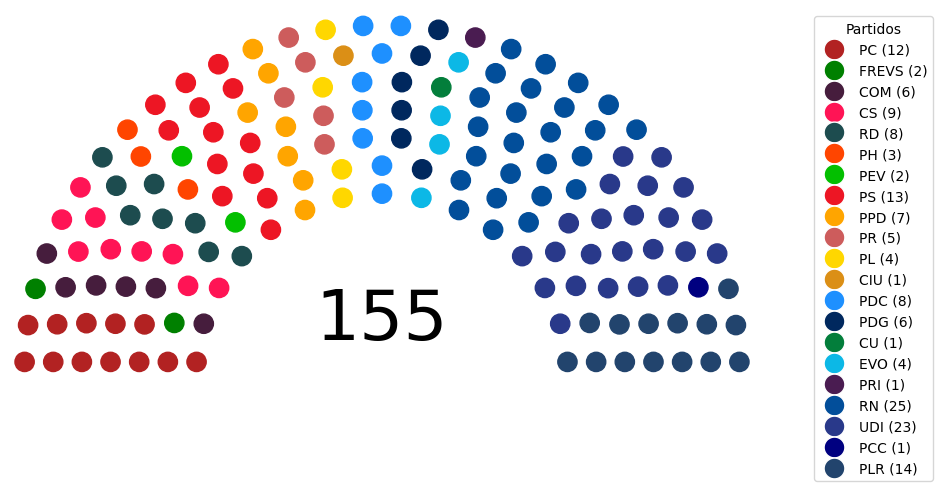

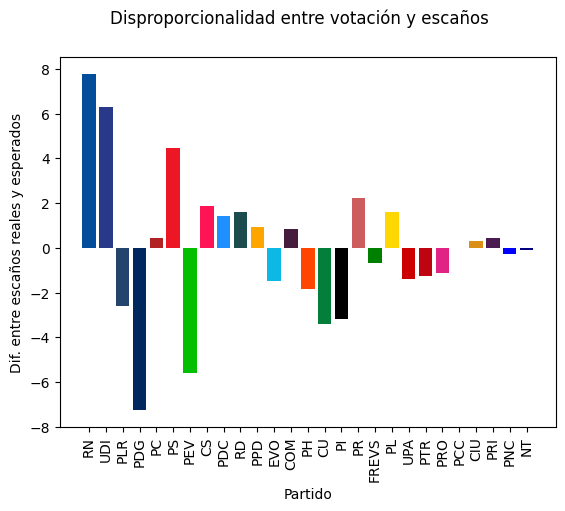

RESUMEN DE ESTADÍSTICAS:

Candidatos con menos votos que fueron electos:
                            Pacto Partido  Distrito  Votos (%)
Candidato                                                     
HERNAN PALMA PEREZ             DA      PH        12   0.239757
MONICA TAMARA ARCE CASTRO      DA      PH        12   0.250215
ANDRES GIORDANO SALAZAR        AD      RD         9   0.856237
MARTA AMERICA GONZALEZ OLEA   NPS     PPD        15   0.989451
ANA MARIA BRAVO CASTRO        NPS      PS        24   1.288526

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      RN         2   9.994307
ALEJANDRA VALDEBENITO TORRES         ChP+     UDI        27   9.910182
LEONARDO DANTE SOLARI ALCOTA          FSC     PLR         2   9.903423
JOHN LEANDRO SANCHO BICHET           ChP+      RN        18   9.148645
CAROLINA CU

In [7]:
results_dhondt = appoint_divisor_district(
    df,
    district_seats=district_seats,
    type="dhondt",
    party_threshold=0.00
)
app_dhondt = Apportionment(
    results=results_dhondt,
    colors=colors,
    party_order=party_order
)

app_dhondt.summary()